# Attention

There are problems where fully connected neural nets and CNNs are not suitable. One of the examples is dealing with sequences of different lengths.

In this notebook, we will see how Self-Attention can solve the sorting problem. Given an arbitrary length sequence of digits, the task is to return sorted one.

```
Input:  [1 1 1 8 4 6 8 5 8 2 6]
Output: [1 1 1 2 4 5 6 6 8 8 8]
```

Let's implement the problem using a generator.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
one_hot = np.eye(10)

def pad(list_of_seq):
    N = max([len(seq) for seq in list_of_seq])
    return torch.stack([F.pad(seq, (0, N - len(seq)))
                        for seq in list_of_seq])

def generator(max_seq_len, batch_size=32):
    one_hot = torch.eye(10)
    while True:
        X = [torch.randint(10, (np.random.randint(max_seq_len),))
             for _ in range(batch_size)]
        y = [torch.sort(x).values for x in X]
        yield F.one_hot(pad(X), num_classes=10).float(), F.one_hot(pad(y), num_classes=10).float()

Now we can take a look at a small batch.

In [3]:
gen = generator(12, batch_size=5)
X, y = next(gen)
for inp, out in zip(X, y):
    print('\nInput: ', inp.argmax(axis=1))
    print('Output:', out.argmax(axis=1))


Input:  tensor([9, 1, 3, 4, 0, 0, 0, 0])
Output: tensor([0, 1, 3, 4, 9, 0, 0, 0])

Input:  tensor([7, 8, 4, 5, 9, 0, 0, 0])
Output: tensor([4, 5, 7, 8, 9, 0, 0, 0])

Input:  tensor([3, 0, 8, 4, 9, 4, 0, 0])
Output: tensor([0, 3, 4, 4, 8, 9, 0, 0])

Input:  tensor([7, 4, 3, 2, 8, 1, 1, 2])
Output: tensor([1, 1, 2, 2, 3, 4, 7, 8])

Input:  tensor([7, 8, 0, 0, 0, 0, 0, 0])
Output: tensor([0, 7, 8, 0, 0, 0, 0, 0])


Note, that due to the padding this problem becomes even harder since 0 has different interpretations depending on where it is located. It is a good idea to pad with -1's instead, but let's stick with the current implementation to make it more challenging for the model.

## Self-Attention

In principle idea of self-attention is quite simple. Input vector gets multiplied by three matrixes - $Q, K, V$ to form **Q**uery, **K**ey and **V**alue vectors. Then **Q**uery and **K**ey are combined between the sequences to get weights which are then used to weight **V**alues before summing them up.

![Attention](img/self_attention.gif)

There are a lot of good explanations online if you want to go deeper and understand the math behind it - https://peterbloem.nl/blog/transformers.

## Transformer Block

To use self-attention effectively we need to harness a couple of tricks. The first is to mix it up with fully connected layers and introduce some skip connections.

![Transformer Block](img/transformer_block.png)

Since it is possible to repeat Transformer Blocks let's a for loop (for now it will be executed only once).

In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden, num_heads):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=hidden, num_heads=num_heads)
        self.fc1 = nn.Linear(hidden, hidden * 4)
        self.fc2 = nn.Linear(hidden * 4, hidden)
        self.layer_norm = nn.LayerNorm(hidden, eps=1e-5)
    
    def forward(self, x):
        x = x.permute(1, 0, 2)
        att, _ = self.attention(x, x, x)
        enc = self.layer_norm(x + att)
        enc = enc.permute(1, 0, 2)
        fcn = F.relu(self.fc1(enc))
        fcn = self.fc2(fcn)
        return self.layer_norm(fcn + enc)

class TransformerModel(nn.Module):
    def __init__(self, hidden=32, num_heads=16, num_blocks=1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(10, hidden)
        self.blocks = nn.ModuleList([TransformerBlock(hidden, num_heads) for _ in range(num_blocks)])
        self.output = nn.Linear(hidden, 10)
        
    def forward(self, x):
        x = self.embedding(x)
        for block in self.blocks:
            x = block(x)
        return F.softmax(self.output(x), dim=-1)

Let's define a helper function that plots sequences and an image and prints out a small sample.

In [5]:
# Define the evaluation function
def eval_model(model, gen, seq_to_print=5):
    model.eval()
    with torch.no_grad():
        X, y = next(gen)
        pred = model(X).argmax(dim=-1)
        real = y.argmax(dim=-1)
        
        # Plotting
        plt.subplot(121)
        plt.imshow(pred)
        plt.axis('off')
        plt.title('Prediction')
        plt.subplot(122)
        plt.imshow(real)
        plt.axis('off')
        plt.title('Actual seq')
        plt.show()
        
        # Print sequences
        for p, a in zip(pred[:seq_to_print], real[:seq_to_print]):
            print('\nPrediction:', p.numpy())
            print('Actual seq:', a.numpy())

Finally we are ready to train a model.

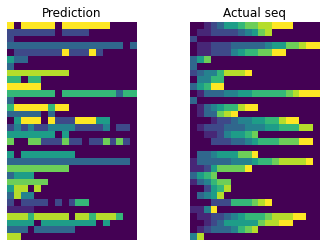


Prediction: [9 0 9 9 9 9 9 0 9 9 9 9 9 9 9 0 0 0 0]
Actual seq: [0 0 1 2 3 5 5 6 7 7 8 8 9 9 9 0 0 0 0]

Prediction: [2 2 2 2 2 2 2 0 2 2 2 2 0 0 0 0 0 0 0]
Actual seq: [0 1 1 2 2 2 2 3 4 5 7 8 0 0 0 0 0 0 0]

Prediction: [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3]
Actual seq: [0 1 1 2 2 2 3 3 3 3 3 4 5 5 7 7 8 9 9]

Prediction: [0 2 2 2 2 2 2 2 9 2 2 2 9 2 0 0 0 0 0]
Actual seq: [0 1 1 2 2 2 4 5 6 6 7 7 9 9 0 0 0 0 0]


In [6]:
# Generate data, build the model, train, and evaluate
gen = generator(max_seq_len=20)
model = TransformerModel()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# For faster demonstration reduce the number of epochs
epochs = 10
steps_per_epoch = 200

# Move model to device (use 'cuda' if available, otherwise 'cpu')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
model.train()
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        X, y = next(gen)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs.permute(0, 2, 1), y.argmax(dim=-1))
        loss.backward()
        optimizer.step()

# Evaluate the model
eval_model(model, gen)

At this point, the model can learn to deal with sequence length and can pick the element that is most common but fails with sorting problem... Clearly, we lack something that allows the model to learn sequential nature.

## Positional Embeddings

To resolve the problem we will add random weights for each position! We fix those *positional embeddings* before generating sequences and then add them to the inputs. The code below should be self-explanatory. 

In [7]:
def positional_generator(max_seq_len):
    positional_embedding = torch.rand((max_seq_len, 10))
    gen = generator(max_seq_len)
    while True:
        X, y = next(gen)
        N = y.shape[1]
        X += positional_embedding[:N]
        yield X, y

Let's retrain the model using updated generator.

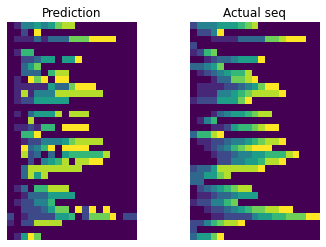


Prediction: [0 1 4 4 5 4 5 7 8 8 0 0 0 0 0 0 0 0 0]
Actual seq: [2 4 4 4 5 5 5 6 7 8 0 0 0 0 0 0 0 0 0]

Prediction: [0 0 2 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [0 2 2 4 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [0 1 1 1 3 1 3 3 3 7 7 7 9 9 9 9 0 0 0]
Actual seq: [0 0 0 1 1 1 1 3 3 3 3 7 7 8 9 9 9 0 0]

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [0 1 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [1 2 6 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
# Generate data, build the model, train, and evaluate
gen = positional_generator(max_seq_len=20)
model = TransformerModel()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

model.train()
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        X, y = next(gen)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs.permute(0, 2, 1), y.argmax(dim=-1))
        loss.backward()
        optimizer.step()

# Evaluate the model
eval_model(model, gen)

Much better! You can try to remove the attention layer to convince yourself that this net will fail without it since that disables the passing of the information about other sequence elements. Actually, if we reformulate this problem for fixed length sequences, then flattening and using simple FCN could work, but with arbitrary length sequences, Attention is a way to go.

## Final Architecture

For sure we can add more layers to get more power. It's already implemented above, we just need to pass `num_blocks=3` when constructing the model.

![Transformer Block](img/transformer.png)

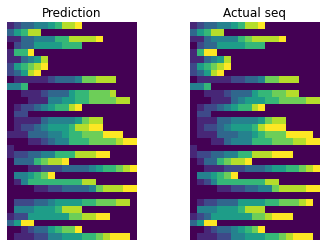


Prediction: [1 2 3 3 4 4 5 6 8 8 9 0 0 0 0 0 0 0 0]
Actual seq: [1 2 3 3 4 4 5 6 8 8 9 0 0 0 0 0 0 0 0]

Prediction: [3 5 6 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [3 5 6 8 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Prediction: [1 1 3 3 4 4 4 6 6 8 8 8 8 9 0 0 0 0 0]
Actual seq: [1 1 3 4 4 4 4 6 7 8 8 8 8 9 0 0 0 0 0]

Prediction: [0 2 3 3 5 5 5 5 6 6 6 0 0 0 0 0 0 0 0]
Actual seq: [0 2 3 3 5 5 5 5 6 6 6 0 0 0 0 0 0 0 0]

Prediction: [1 6 6 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual seq: [1 6 9 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [9]:
epochs = 30

# Train another model with three blocks of attention layers using the positional generator
gen = positional_generator(max_seq_len=20)
model = TransformerModel(num_blocks=3).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

# Train the model
model.train()
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        X, y = next(gen)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs.permute(0, 2, 1), y.argmax(dim=-1))
        loss.backward()
        optimizer.step()

# Evaluate the model
eval_model(model, gen)

Training is still quite fast and this time results are nearly perfect. From time to time model messes up with zeros, but that is expected as discussed in the problem formulation.

## TASK: Sequence prediction

Your goal is to make a model capable of predicting how the sequence will continue. We will use generated sequences comprised of two sinus waves with some added noise.

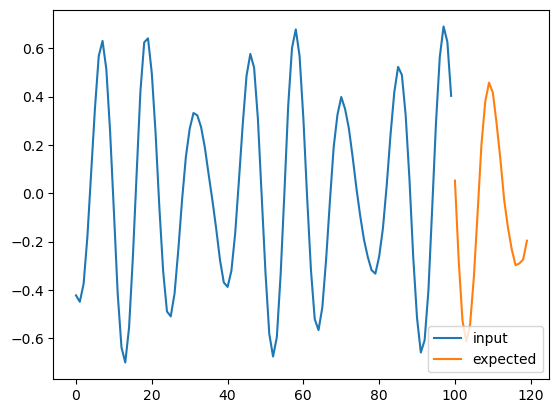

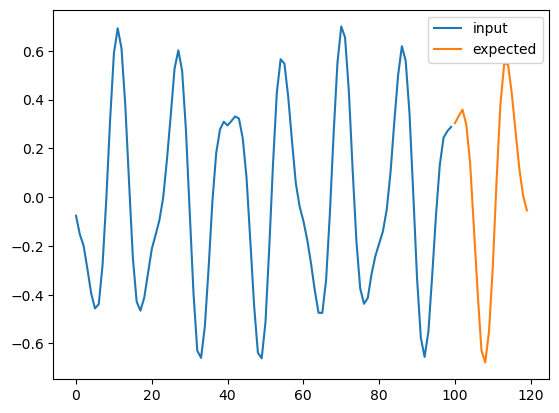

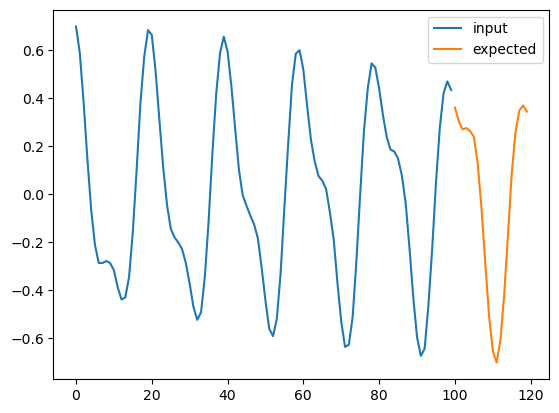

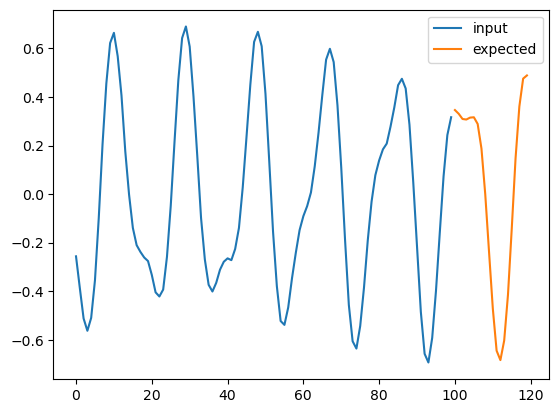

In [5]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 30 + 30))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 60 + 60)) # + wave 2
    series += 0.02 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

n_steps = 100
pred_steps = 20
series = generate_time_series(10000, n_steps + pred_steps)

X_train, Y_train = series[:7000, :n_steps], series[:7000, -pred_steps:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -pred_steps:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -pred_steps:, 0]

# Train a model and make prediction, then validate it using the plots

for i in range(4):
    plt.plot(np.arange(n_steps), X_test[i], label='input')
    plt.plot(np.arange(n_steps, n_steps + pred_steps), Y_test[i], label='expected')
    # plt.plot(np.arange(n_steps, n_steps + pred_steps), pred[i], label='prediction')
    plt.legend()
    plt.show()

## Age of Transformers

Attention is widely used for language and is finding its way into language, voice, vision, and basically any field that uses sequences or can be expressed as a sequence. It was popularized with a paper named [Attention Is All You Need](https://arxiv.org/abs/1706.03762). Usually similarly to autoencoders, there is a block that encodes input data followed by a decoder. It can be from the same domain, for example as in translation problems, but even more interestingly it can be different domains, for example, encoding text and then decoding it as an image!

Widely known [GPT-3](https://openai.com/api/) used Transformers with attention to creating stunning text completions that can seam intelligent. It is common to see attention used in summarization, [translation](https://www.deepl.com/translator), and text classification solutions. [DALL-E 2](https://openai.com/dall-e-2/) as well as [midjourney](https://www.midjourney.com/showcase/) used them to create stunning art from the text descriptions.

### Honorable mentions

Best way to get into transformers is digging into HuggingFace. Also I would recommend this intro podcast: [Cambrian Explosion of generative models](https://changelog.com/practicalai/230).
- HuggingFace Transformers - https://huggingface.co/docs/transformers/index
- HuggingFace Spaces - https://huggingface.co/spaces?sort=likes
- HuggingFace Downloads - https://huggingface.co/models?p=2&sort=downloads

**BERT (encoder)**
- BookCorpus (11k books) + Wikipedia
- mask any word in sentance
- bidirectional
- designed for fine-tunning
- focus on comprehension (classification, question-answering, and named entity recognition)
- BERT - https://huggingface.co/docs/transformers/model_doc/bert

**GPT2 (decoder)**
- 8 million web pages, ~40 GB of text data
- trained to predict next word
- unidirectional
- produces coherent and contextually relevant language output
- GPT2 - https://huggingface.co/docs/transformers/model_doc/gpt2

**ViT**
- ImageNet (14mln) + JFT (300mln)
- optimized for single-label image classification
- ViT adapts the Transformer model, originally used in NLP, for image processing
- ViT treats an image as a sequence of fixed-size patches
- ViT - https://huggingface.co/docs/transformers/model_doc/vit

**CLIP**
- WebImageText (hundreds of millions of image-text pairs)
- linking images and text for classification, image/text retrieval, visual question answering
- image encoder (ViT) + text encoder (Transformer)
- CLIP learns to match corresponding pairs of images and texts
- CLIP can perform classification tasks on categories it has never seen during training, a process known as zero-shot learning
- CLIP - https://huggingface.co/docs/transformers/model_doc/clip
- Blog post about CLIP - https://openai.com/research/clip
- OpenCLIP - https://github.com/mlfoundations/open_clip
- CLIP Interrogator - https://huggingface.co/spaces/pharmapsychotic/CLIP-Interrogator

**OWL-ViT**
- 3.6 billion image-text pairs
- A distinctive feature of OWL-ViT is its focus on object-level understanding. This means it not only looks at an image as a whole but also pays attention to individual objects within the image and their relations.
- OWL-ViT - https://huggingface.co/docs/transformers/model_doc/owlvit

**BLIP-2**
- Dataset is unknown (paper mentions that the model is pre-trained on a combination of dataset, including COCO, Visual Genome, CC, SBU and LAION)
- has generative properties, thus can be used for image captioning, visual question answering, text/image retrieval
- focused on generating and understanding detailed text in relation to images
- BLIP-2 - https://huggingface.co/docs/transformers/model_doc/blip-2
- How to use BLIP-2 - https://huggingface.co/blog/blip-2

**Stable Diffusion**
- LAION-5B (Common Crawl data scraped from the web, 5 billion image-text pairs)
- Base model compresses to latent space and then Refiner guides it backwards
- Stable Diffusion model - https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0
- Stability AI repo - https://github.com/Stability-AI/generative-models
- Stable Diffusion 2.1 Demo - https://huggingface.co/spaces/stabilityai/stable-diffusion

**Whisper**
- 680k hours of multilingual and multitask data (117k non-english)
- Next token prediction from Log-mel spectogram using Transformer architecture
- Whisper - https://openai.com/research/whisper

Other links
- DALL-E 3 - https://openai.com/dall-e-3
- DALL-E 2 used CLIP - https://vitalflux.com/wp-content/uploads/2023/05/DALL-E-2-architecture.png
- LocalAI - https://github.com/mudler/LocalAI
- LLM dev patterns - https://eugeneyan.com/writing/llm-patterns/
- LLM attacks - https://llm-attacks.org/

Note: people use GPT as a data generator for their projects.

## (re)Sources:

- Good explanation - https://peterbloem.nl/blog/transformers
- More simple examples - https://github.com/greentfrapp/attention-primer
- [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

